#  Programming assignment 6: Fine-tuning InceptionV3 for flowers classification

In this task you will fine-tune InceptionV3 architecture for flowers classification task.

InceptionV3 architecture (https://research.googleblog.com/2016/03/train-your-own-image-classifier-with.html):
<img src="images/inceptionv3.png" style="width:70%">

Flowers classification dataset (http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) consists of 102 flower categories commonly occurring in the United Kingdom. Each class contains between 40 and 258 images:
<img src="images/flowers.jpg" style="width:70%">

# Import stuff

In [1]:
import sys
sys.path.append("..")
import grading
import download_utils

In [2]:
download_utils.link_all_keras_resources()

In [3]:
import tensorflow as tf
import keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)
import cv2  # for image processing
from sklearn.model_selection import train_test_split
import scipy.io
import os
import tarfile
import tqdm
import keras_utils

Using TensorFlow backend.


1.2.1
2.0.6


# Fill in your Coursera token and email
To successfully submit your answers to our grader, please fill in your Coursera submission token and email

In [6]:
grader = grading.Grader(assignment_key="2v-uxpD7EeeMxQ6FWsz5LA", 
                        all_parts=["wuwwC", "a4FK1", "qRsZ1"])

In [7]:
# token expires every 30 min
COURSERA_TOKEN = ""
COURSERA_EMAIL = ""

# Load dataset

Dataset was downloaded for you, it takes 12 min and 400mb.
Relevant links (just in case):
- http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html
- http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
- http://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat

In [9]:
# we downloaded them for you, just link them here
download_utils.link_week_3_resources()

# Prepare images for model

In [10]:
# we will crop and resize input images to IMG_SIZE x IMG_SIZE
IMG_SIZE = 250

In [11]:
def decode_image_from_raw_bytes(raw_bytes):
    img = cv2.imdecode(np.asarray(bytearray(raw_bytes), dtype=np.uint8), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

We will take a center crop from each image like this:
<img src="images/center_crop.jpg" style="width:50%">

In [12]:
def image_center_crop(img):
    """
    Makes a square center crop of an img, which is a [h, w, 3] numpy array.
    Returns [min(h, w), min(h, w), 3] output with same width and height.
    For cropping use numpy slicing.
    """
    h, w, _ = img.shape
    a = min(h, w)
    cropped_img = img[(h-a)//2:h-(h-a)//2,(w-a)//2:w-(w-a)//2,:]
    
    return cropped_img

In [13]:
def prepare_raw_bytes_for_model(raw_bytes, normalize_for_model=True):
    img = decode_image_from_raw_bytes(raw_bytes)  # decode image raw bytes to matrix
    img = image_center_crop(img)  # take squared center crop
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # resize for our model
    if normalize_for_model:
        img = img.astype("float32")  # prepare for normalization
        img = keras.applications.inception_v3.preprocess_input(img)  # normalize for model
    return img

In [14]:
# reads bytes directly from tar by filename (slow, but ok for testing, takes ~6 sec)
def read_raw_from_tar(tar_fn, fn):
    with tarfile.open(tar_fn) as f:
        m = f.getmember(fn)
        return f.extractfile(m).read()

(500, 591, 3)


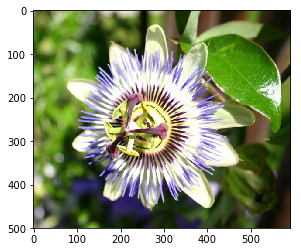

(250, 250, 3)


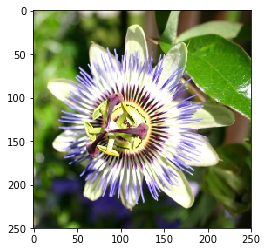

In [15]:
# test cropping
raw_bytes = read_raw_from_tar("102flowers.tgz", "jpg/image_00001.jpg")

img = decode_image_from_raw_bytes(raw_bytes)
print(img.shape)
plt.imshow(img)
plt.show()

img = prepare_raw_bytes_for_model(raw_bytes, normalize_for_model=False)
print(img.shape)
plt.imshow(img)
plt.show()

In [16]:
## GRADED PART, DO NOT CHANGE!
# Test image preparation for model
prepared_img = prepare_raw_bytes_for_model(read_raw_from_tar("102flowers.tgz", "jpg/image_00001.jpg"))
grader.set_answer("qRsZ1", list(prepared_img.shape) + [np.mean(prepared_img), np.std(prepared_img)])

In [17]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!


# Prepare for training

In [18]:
# read all filenames and labels for them

# read filenames firectly from tar
def get_all_filenames(tar_fn):
    with tarfile.open(tar_fn) as f:
        return [m.name for m in f.getmembers() if m.isfile()]

all_files = sorted(get_all_filenames("102flowers.tgz"))  # list all files in tar sorted by name
all_labels = scipy.io.loadmat('imagelabels.mat')['labels'][0] - 1  # read class labels (0, 1, 2, ...)
# all_files and all_labels are aligned now
N_CLASSES = len(np.unique(all_labels))
print(N_CLASSES)

102


In [19]:
# split into train/test
tr_files, te_files, tr_labels, te_labels = \
    train_test_split(all_files, all_labels, test_size=0.2, random_state=42, stratify=all_labels)

In [20]:
# will yield raw image bytes from tar with corresponding label
def raw_generator_with_label_from_tar(tar_fn, files, labels):
    label_by_fn = dict(zip(files, labels))
    with tarfile.open(tar_fn) as f:
        for m in f.getmembers():  # listing members is slow, but then it's fast!
            if m.name in label_by_fn:
                yield f.extractfile(m).read(), label_by_fn[m.name]

In [21]:
# batch generator
BATCH_SIZE = 32

def batch_generator(items, batch_size):
    """
    Implement batch generator that yields items in batches of size batch_size.
    There's no need to shuffle input items, just chop them into batches.
    Remember about the last batch that can be smaller than batch_size!
    Input: any iterable (list, generator, ...). You should do `for item in items: ...`
        In case of generator you can pass through your items only once!
    Output: In output yield each batch as a list of items.
    """
    
    batch = [None] * batch_size
    for i, item in enumerate(items):
        batch[i%batch_size] = item
        if i%batch_size == batch_size-1:
            yield batch
            batch = [None] * batch_size
    if batch[0]:
        yield [item for item in batch if item]

In [22]:
## GRADED PART, DO NOT CHANGE!
# Test batch generator
def _test_items_generator():
    for i in range(10):
        yield i

grader.set_answer("a4FK1", list(map(lambda x: len(x), batch_generator(_test_items_generator(), 3))))

In [23]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!


In [24]:
def train_generator(files, labels):
    while True:  # so that Keras can loop through this as long as it wants
        for batch in batch_generator(raw_generator_with_label_from_tar(
                "102flowers.tgz", files, labels), BATCH_SIZE):
            # prepare batch images
            batch_imgs = []
            batch_targets = []
            for raw, label in batch:
                img = prepare_raw_bytes_for_model(raw)
                batch_imgs.append(img)
                batch_targets.append(label)
            # stack images into 4D tensor [batch_size, img_size, img_size, 3]
            batch_imgs = np.stack(batch_imgs, axis=0)
            # convert targets into 2D tensor [batch_size, num_classes]
            batch_targets = keras.utils.np_utils.to_categorical(batch_targets, N_CLASSES)
            yield batch_imgs, batch_targets

(32, 250, 250, 3) (32, 102)


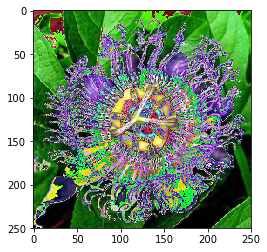

In [25]:
# test training generator
for _ in train_generator(tr_files, tr_labels):
    print(_[0].shape, _[1].shape)
    plt.imshow(_[0][0])
    break

# Training

You cannot train such a huge architecture from scratch with such a small dataset.

But using fine-tuning of last layers of pre-trained network you can get a pretty good classifier very quickly.

In [53]:
# remember to clear session if you start building graph from scratch!
K.clear_session()
# don't call K.set_learning_phase() !!! (otherwise will enable dropout in train/test simultaneously)

In [26]:
def inception(use_imagenet=True):
    # load pre-trained model graph, don't add final layer
    model = keras.applications.InceptionV3(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                          weights='imagenet' if use_imagenet else None)
    # add global pooling just like in InceptionV3
    new_output = keras.layers.GlobalAveragePooling2D()(model.output)
    # add new dense layer for our labels
    new_output = keras.layers.Dense(N_CLASSES, activation='softmax')(new_output)
    model = keras.engine.training.Model(model.inputs, new_output)
    return model

In [27]:
model = inception()

In [28]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 250, 250, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 124, 124, 32)  864         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 124, 124, 32)  96          conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 124, 124, 32)  0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [29]:
# how many layers our model has
print(len(model.layers))

313


In [30]:
# set all layers trainable by default and prepare batch norm for fine-tuning
for layer in model.layers:
    layer.trainable = True
    if isinstance(layer, keras.layers.BatchNormalization):
        # we do aggressive exponential smoothing of batch norm 
        # parameters to faster adjust to our new dataset
        layer.momentum = 0.8
    
# fix deep layers (fine-tuning only last 50)
for layer in model.layers[:-50]:
    layer.trainable = False

In [31]:
# compile new model
model.compile(
    loss='categorical_crossentropy',  # we train 102-way classification
    optimizer=keras.optimizers.adamax(lr=1e-2),  # we can take big lr here because we fixed first layers
    metrics=['accuracy']  # report accuracy during training
)

In [32]:
# fine tune for 2 epochs
model.fit_generator(
    train_generator(tr_files, tr_labels), 
    steps_per_epoch=len(tr_files) // BATCH_SIZE, 
    epochs=2,
    validation_data=train_generator(te_files, te_labels), 
    validation_steps=len(te_files) // BATCH_SIZE // 2,
    callbacks=[keras_utils.TqdmProgressCallback()],
    verbose=0
)

Epoch 1/2

Epoch 2/2



In [33]:
## GRADED PART, DO NOT CHANGE!
# Accuracy on validation set
test_accuracy = model.evaluate_generator(
    train_generator(te_files, te_labels), 
    len(te_files) // BATCH_SIZE // 2
)[1]
grader.set_answer("wuwwC", test_accuracy)
print(test_accuracy)

0.93125


In [ ]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

That's it! Congratulations!

What you've done:
- prepared images for the model
- implemented your own batch generator
- fine-tuned the pre-trained model